# SOLVERS

Importing the relevant libraries:

In [1]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import PIL

import time

from mip import *
import cplex
from cplex.exceptions import CplexError

Defining the generator:

In [2]:
# Class that will help create a connected graph

class UnionFind:
    def __init__(self, n):
        self.n = n  # number of trees in the forest
        self.v = [i for i in range(n)]  # initialize each disjoint set

    def find(self, u):
        while u != self.v[u]:
            self.v[u] = self.v[self.v[u]]  # compression technique
            u = self.v[u]
            
        return u
    
    def union(self, u, v):
        root_u, root_v = self.find(u), self.find(v)
        
        if root_u == root_v:
            return False  # union was not performed
        else:
            self.v[root_v] = root_u
            self.n -= 1

            return True  # union was not performed
        
# Defining the generator
        
class GraphGenerator:
    def __init__(self, N=100):
        self.N = N  # number os cells (default is a 10x10 grid)
        self.edges = self.generate_edges()
        
    def water_network(self):        
        # Copy the edges and create a disjoint set for each cell
        edges = self.edges.copy()
        forest = UnionFind(self.N)
        
        # Generate a graph
        G = nx.Graph()
        
        # Adding nodes
        # Initial value of flow is True because, initially, it is a connected graph
        for v in range(self.N):
            G.add_node(v, node_prop=None, flow=True, image=images["node_water"])
            
        step = 2*(self.N**0.5) + 2
            
        origin = np.random.randint(0, self.N)
        dest = np.random.choice([v for v in range(self.N) if v < origin-step or v > origin+step])
    
        G.nodes[origin]["node_prop"] = "origin"
        G.nodes[origin]["image"] = images["origin"]
        G.nodes[dest]["node_prop"] = "dest"
        G.nodes[dest]["image"] = images["dest"]
        
        # Adding edges
        # Makes sure that the initial graph will be connected
        # Edges with endpoint at origin or destination are marked as red
        # This color represents the constraint that prevents the deletion of an edge
        while forest.n > 1:
            v, w = edges.pop(np.random.randint(0, len(edges)))
            forest.union(v, w)
            G.add_edge(v, w, color="red" if G.nodes[v]["node_prop"] or G.nodes[w]["node_prop"] else "blue")
            
        return G
    
    def military_network(self):        
        # Copy the edges and create a disjoint set for each cell
        edges = self.edges.copy()
        forest = UnionFind(self.N)
        
        # Generate a graph
        G = nx.Graph()
        
        # Adding nodes
        endurances = np.random.choice(np.arange(1, 4), self.N, [0.2, 0.2, 0.6])
        for v, e in enumerate(endurances):
            G.add_node(v, node_prop=None, endurance=e, provided=True, image=images[f"base_{e}"])
            
        headquarters = np.random.randint(0, self.N)
    
        G.nodes[headquarters]["node_prop"] = "headquarters"
        G.nodes[headquarters]["endurance"] = 10000  # headquarters is the most difficult enemy military installation to attack
        G.nodes[headquarters]["image"] = images["headquarters"]
        
        # Adding edges
        # Makes sure that the initial graph will be connected
        while forest.n > 1:
            v, w = edges.pop(np.random.randint(0, len(edges)))
            forest.union(v, w)
            G.add_edge(v, w)
            
        # Harder to attack military installations adjacent to headquarters
        if v in G[headquarters]:
            G.nodes[v]["node_prop"] = "secure"
            G.nodes[v]["endurance"] = 100
                
        return G
                
    def available_edges(self, v):
        shape = int(self.N**0.5)  # takes into account the dimensions of the grid
        
        available_edges = []
        if (v+1) % shape != 0:
            available_edges.append((v, v+1))
        if v+shape < self.N:
            available_edges.append((v, v+shape))

        return available_edges  # possible edges in cell v

    def generate_edges(self):
        edges = []
        
        for v in range(self.N):
            edges.extend(self.available_edges(v))

        return edges

Defining function to display the water distribution network:

In [3]:
# Load images and defining constants

files = {"node_water" : "../media/node_water.png",
         "node" : "../media/node.png",
         "origin" : "../media/origin.png",
         "dest" : "../media/dest.png",
         "headquarters" : "../media/headquarters.png",
         "base_1" : "../media/base_1.png",
         "base_2" : "../media/base_2.png",
         "base_3" : "../media/base_3.png"}

images = {name : PIL.Image.open(file) for name, file in files.items()}

pos = {
    0: np.array([-0.51696583,  0.93714869]),
    1: np.array([-0.56742641,  0.82253354]),
    2: np.array([-0.62719935,  0.6729658 ]),
    3: np.array([-0.68765874,  0.50267799]),
    4: np.array([-0.74382698,  0.32035925]),
    5: np.array([-0.7941627 ,  0.13217055]),
    6: np.array([-0.83666331, -0.05578246]),
    7: np.array([-0.86996528, -0.23595114]),
    8: np.array([-0.89094869, -0.39926238]),
    9: np.array([-0.89163946, -0.53053518]),
    10: np.array([-0.38733367,  0.91693445]),
    11: np.array([-0.43712311,  0.80092016]),
    12: np.array([-0.49716983,  0.65037759]),
    13: np.array([-0.5581313 ,  0.48008344]),
    14: np.array([-0.61608378,  0.29792199]),
    15: np.array([-0.66749135,  0.10980975]),
    16: np.array([-0.71289509, -0.07778028]),
    17: np.array([-0.74890233, -0.25729352]),
    18: np.array([-0.77561893, -0.41942676]),
    19: np.array([-0.79111634, -0.54694834]),
    20: np.array([-0.21763917,  0.88636633]),
    21: np.array([-0.26705243,  0.77026095]),
    22: np.array([-0.32663326,  0.61904439]),
    23: np.array([-0.38874385,  0.44821624]),
    24: np.array([-0.44925398,  0.26544396]),
    25: np.array([-0.503791  ,  0.07726947]),
    26: np.array([-0.55185069, -0.1106987 ]),
    27: np.array([-0.59258626, -0.28972098]),
    28: np.array([-0.6253616 , -0.45151689]),
    29: np.array([-0.64908797, -0.57808267]),
    30: np.array([-0.0265184 ,  0.84316223]),
    31: np.array([-0.07569189,  0.72768255]),
    32: np.array([-0.13522642,  0.57630147]),
    33: np.array([-0.19846837,  0.4052692 ]),
    34: np.array([-0.26184534,  0.22231268]),
    35: np.array([-0.31914537,  0.03504394]),
    36: np.array([-0.37176953, -0.15155968]),
    37: np.array([-0.41760519, -0.33009058]),
    38: np.array([-0.45635494, -0.49089175]),
    39: np.array([-0.48610726, -0.61664203]),
    40: np.array([0.17306041, 0.7870388 ]),
    41: np.array([0.12523073, 0.67174665]),
    42: np.array([0.06542014, 0.52135366]),
    43: np.array([0.00057418, 0.35038808]),
    44: np.array([-0.06446017,  0.16881244]),
    45: np.array([-0.12665467, -0.01764184]),
    46: np.array([-0.18358474, -0.20284045]),
    47: np.array([-0.23517585, -0.37993201]),
    48: np.array([-0.28008131, -0.5395554 ]),
    49: np.array([-0.31520095, -0.66452575]),
    50: np.array([0.37367169, 0.71735255]),
    51: np.array([0.3261134 , 0.60349739]),
    52: np.array([0.26568384, 0.4533447 ]),
    53: np.array([0.20029084, 0.28232821]),
    54: np.array([0.13188387, 0.10076766]),
    55: np.array([ 0.06580071, -0.08512693]),
    56: np.array([ 0.00327433, -0.26912593]),
    57: np.array([-0.05435863, -0.44475043]),
    58: np.array([-0.10542573, -0.60277577]),
    59: np.array([-0.14543593, -0.72631346]),
    60: np.array([0.56559421, 0.6370167 ]),
    61: np.array([0.51816683, 0.52173925]),
    62: np.array([0.45742793, 0.37180072]),
    63: np.array([0.39078859, 0.20081206]),
    64: np.array([0.32068581, 0.01991257]),
    65: np.array([ 0.25061104, -0.16499424]),
    66: np.array([ 0.18319807, -0.34754591]),
    67: np.array([ 0.11983138, -0.52158416]),
    68: np.array([ 0.06301685, -0.6776568 ]),
    69: np.array([ 0.0186711 , -0.79902472]),
    70: np.array([0.73944725, 0.54937204]),
    71: np.array([0.69356718, 0.43354057]),
    72: np.array([0.63327831, 0.28299777]),
    73: np.array([0.56640157, 0.11362039]),
    74: np.array([ 0.49475948, -0.06586195]),
    75: np.array([ 0.42219951, -0.24879945]),
    76: np.array([ 0.3508318 , -0.42919368]),
    77: np.array([ 0.28323608, -0.60006218]),
    78: np.array([ 0.22174755, -0.75283945]),
    79: np.array([ 0.17375926, -0.87138453]),
    80: np.array([0.88851998, 0.46293385]),
    81: np.array([0.84461033, 0.34637144]),
    82: np.array([0.78622939, 0.19742634]),
    83: np.array([0.71890696, 0.03077887]),
    84: np.array([ 0.64701115, -0.14610216]),
    85: np.array([ 0.57298256, -0.32634267]),
    86: np.array([ 0.4991802 , -0.50380042]),
    87: np.array([ 0.42843525, -0.67146086]),
    88: np.array([ 0.36371804, -0.82063715]),
    89: np.array([ 0.31246931, -0.93602742]),
    90: np.array([1.        , 0.39207751]),
    91: np.array([0.95865002, 0.27626818]),
    92: np.array([0.90164736, 0.12886004]),
    93: np.array([ 0.83495187, -0.03602707]),
    94: np.array([ 0.76248999, -0.21032434]),
    95: np.array([ 0.68749931, -0.38815742]),
    96: np.array([ 0.61223136, -0.5631032 ]),
    97: np.array([ 0.53957587, -0.72800535]),
    98: np.array([ 0.47280378, -0.87360199]),
    99: np.array([ 0.41929671, -0.98512662])
}

def plot_water_network(network):
    fig, ax = plt.subplots(figsize=(24, 16))

    nx.draw_networkx_edges(network, pos=pos, ax=ax, width=6,
                           edge_color=nx.get_edge_attributes(network, "color").values())
    nx.draw_networkx_edge_labels(network, pos, {edge : str(edge) for edge in network.edges})

    tr_figure = ax.transData.transform
    tr_axes = fig.transFigure.inverted().transform

    icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.005
    icon_center = icon_size / 2.0

    for n in network.nodes:
        xf, yf = tr_figure(pos[n])
        xa, ya = tr_axes((xf, yf))

        a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])

        a.imshow(network.nodes[n]["image"])
        a.axis("off")

    plt.show()

## MIP Solver

Class to perform the otimization:

In [4]:
def mip_water_network(network):
    for node, prop in network.nodes.data("node_prop"):
        if prop == "origin":
            origin = node
        elif prop == "dest":
            dest = node
            
    # Create a model
    model = Model(sense=MINIMIZE, solver_name=CBC)
    
    # Defining the variables
    x = [model.add_var(var_type=BINARY, name=f"x_{i}")
         for i in network.nodes]
    y = {(i, j) : model.add_var(var_type=BINARY, name=f"y_{i}_{j}")
         for i, j in network.edges}
    
    # Defining the objective function
    model.objective = xsum(y_ij for y_ij in y.values())
        
    # Defining the constraints
    model += x[origin] == 0
    model += x[dest] == 1
    
    for v, w in network.edges:
        model += y[v, w] >= x[v] - x[w]
        model += y[v, w] >= x[w] - x[v]
        
        if network[v][w]["color"] == "red":
            model += y[v, w] == 0
    
    return model

Testing the MIP solver:

In [5]:
# Generating a graph representing a water distribution network

generator = GraphGenerator()

water_network = generator.water_network()

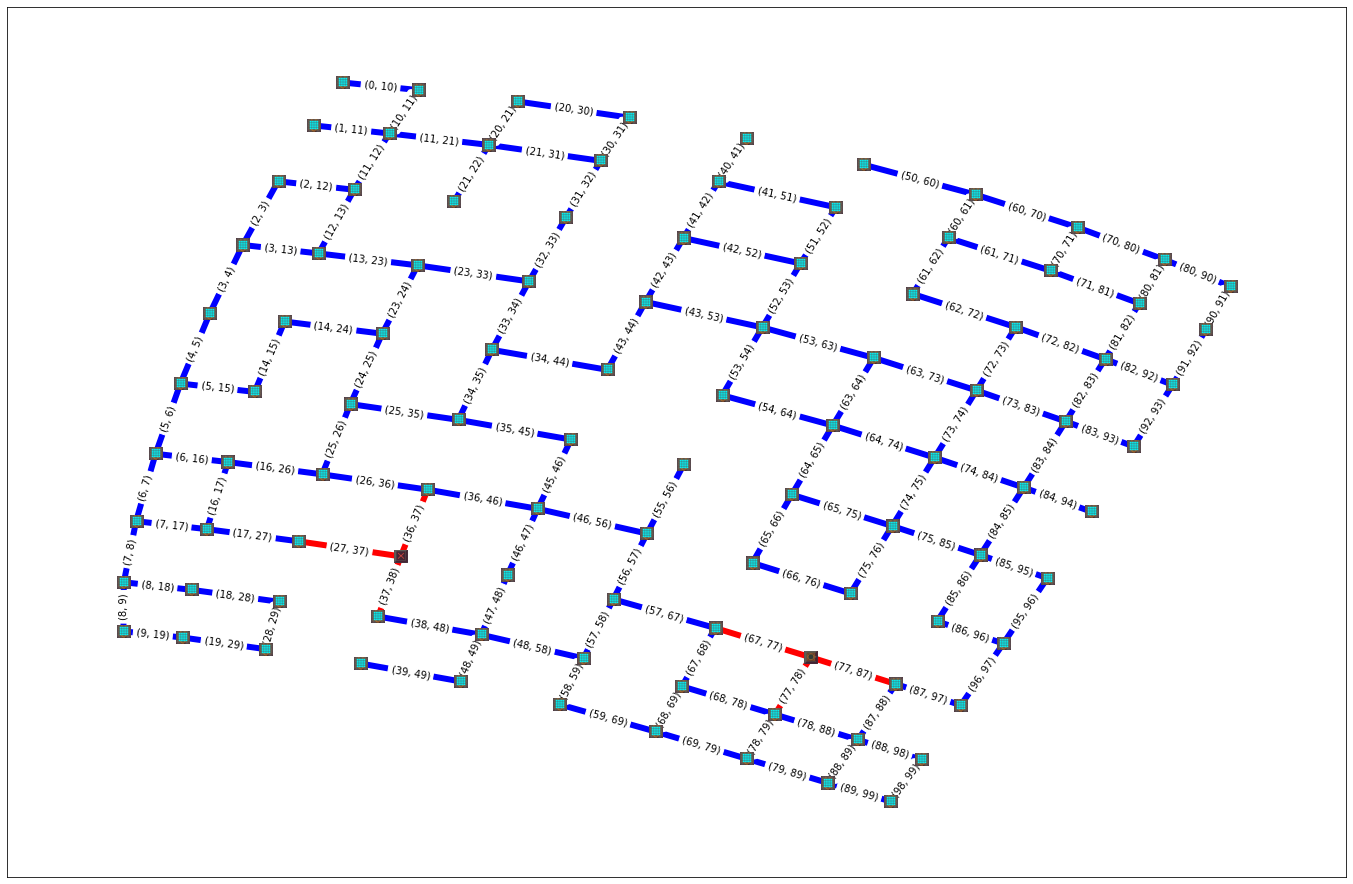

In [6]:
plot_water_network(water_network)

In [7]:
model = mip_water_network(water_network)
model.optimize()

Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Nov 15 2020 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 243 (-31) rows, 219 (-14) columns and 718 (-88) elements
Clp1000I sum of infeasibilities 3.52329e-05 - average 1.44991e-07, 62 fixed columns
Coin0506I Presolve 243 (0) rows, 157 (-62) columns and 594 (-124) elements
Clp0029I End of values pass after 157 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000006 - largest nonzero change 2.8682824e-05 ( 0.0014341412%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Coin0511I After Postsolve, objective 3, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Coin0511I After Postsolve, objective 3, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 3 - 0 iterations time 0.022, Presolv

<OptimizationStatus.OPTIMAL: 0>

In [8]:
print(f"Optimization status is \"{model.status.name}\".")
      
print()
      
print("Getting the results:")
print(f"Optimal solution = {model.objective_value}")

print()

# Displaying variables that have been assigned a 1
for v in model.vars[100:]:
    if v.x:
        print(f"{v.name} = {v.x}")

Optimization status is "OPTIMAL".

Getting the results:
Optimal solution = 3.0

y_34_44 = 1.0
y_46_56 = 1.0
y_48_58 = 1.0


In [9]:
# Removing edges obtained by the model and checking the result

for (v, w), var in zip(water_network.edges, model.vars[100:]):
    if var.x:
        water_network.remove_edge(v, w)

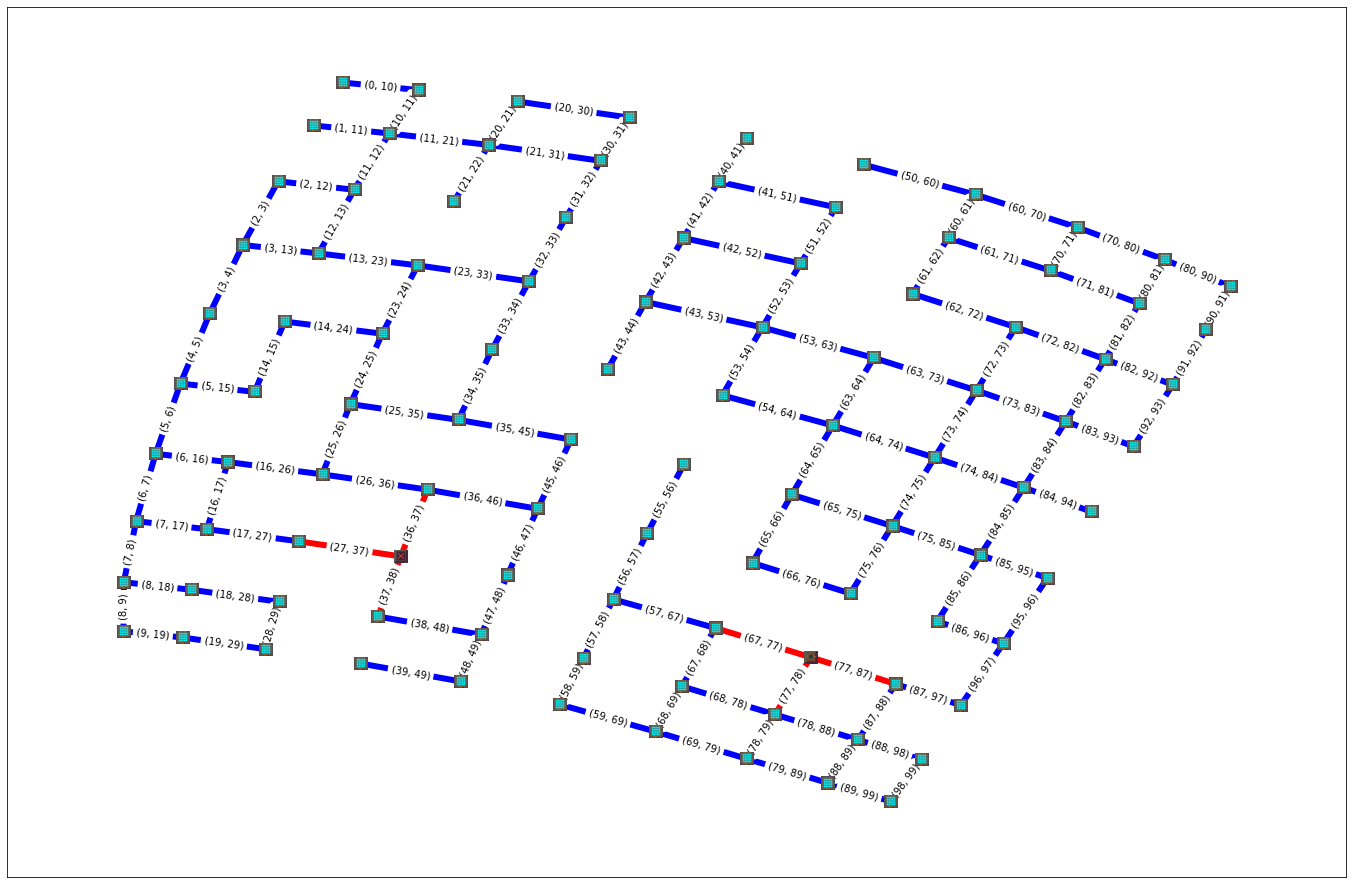

In [10]:
plot_water_network(water_network)

## CPLEX Solver

In [11]:
def cplex_water_network(network):
    for node, prop in network.nodes.data("node_prop"):
        if prop == "origin":
            origin = node
        elif prop == "dest":
            dest = node

    # Create a model
    model = cplex.Cplex()
    model.objective.set_sense(model.objective.sense.minimize)

    model.parameters.lpmethod.set(model.parameters.lpmethod.values.network)

    # Create variables
    x = list(model.variables.add(obj=[0]*network.number_of_nodes(),
                                 ub=[1]*network.number_of_nodes(),
                                 types=["B"]*network.number_of_nodes()))
    y = dict(zip(network.edges, model.variables.add(obj=[1]*network.number_of_edges(),
                                                    ub=[1]*network.number_of_edges(),
                                                    types=["B"]*network.number_of_edges())))

    # Defining the constraints 
    model.linear_constraints.add(lin_expr=[[[x[origin]], [1]]],
                                 senses=["E"], rhs=[0])
    model.linear_constraints.add(lin_expr=[[[x[dest]], [1]]],
                                 senses=["E"], rhs=[1])

    for v, w in network.edges:
        model.linear_constraints.add(lin_expr=[[[y[v, w], x[v], x[w]], [-1, 1, -1]]],
                                     senses=["L"], rhs=[0.0])
        model.linear_constraints.add(lin_expr=[[[y[v, w], x[w], x[v]], [-1, 1, -1]]],
                                     senses=["L"], rhs=[0.0])

        if network[v][w]["color"] == "red":
            model.linear_constraints.add(lin_expr=[[[y[v, w]], [1]]],
                                         senses=["E"], rhs=[0.0])

    return model

Testing the CPLEX solver:

In [12]:
# Generating a graph representing a water distribution network

generator = GraphGenerator()

water_network = generator.water_network()

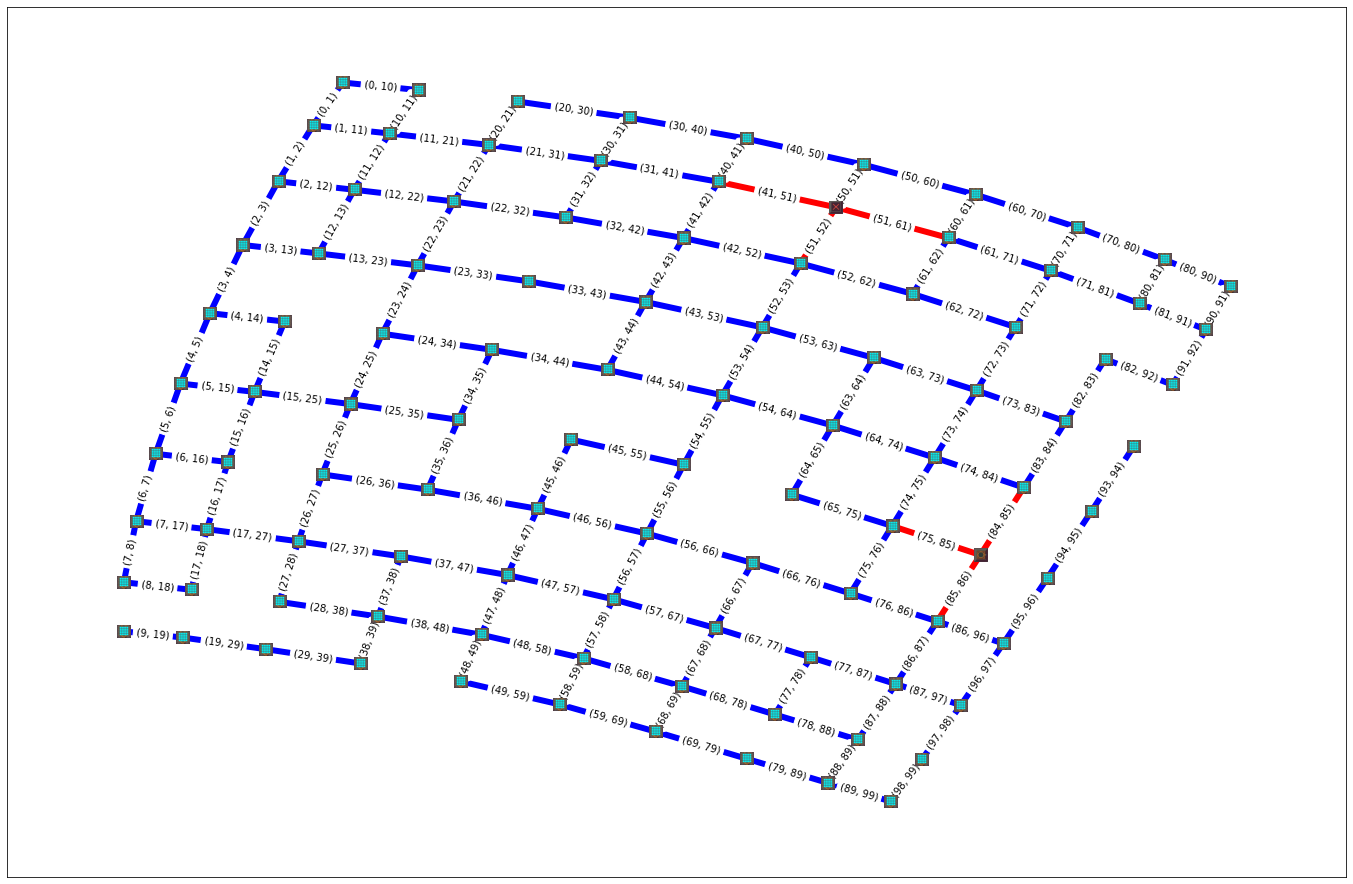

In [13]:
plot_water_network(water_network)

In [14]:
model = cplex_water_network(water_network)
model.solve()

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 106 rows and 64 columns.
Aggregator did 19 substitutions.
Reduced MIP has 192 rows, 157 columns, and 576 nonzeros.
Reduced MIP has 157 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.36 ticks)
Found incumbent of value 8.000000 after 0.01 sec. (1.47 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 192 rows, 157 columns, and 576 nonzeros.
Reduced MIP has 157 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.37 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (0.43 ticks)

        Nodes             

In [15]:
print(f"Optimization status is \"{model.solution.status[model.solution.get_status()]}\".")
      
print()
      
print("Getting the results:")
print(f"Optimal solution = {model.solution.get_objective_value()}")

print()

# Displaying variables that have been assigned a 1
for (v, w), value in zip(water_network.edges, model.solution.get_values()[100:]):
    if value:
        print(f"y_{v}_{w} = {value}")

Optimization status is "MIP_optimal".

Getting the results:
Optimal solution = 7.0

y_64_65 = 1.0
y_66_76 = 1.0
y_74_75 = 1.0
y_74_84 = 1.0
y_83_84 = 1.0
y_86_87 = 1.0
y_96_97 = 1.0


In [16]:
# Removing edges obtained by the model and checking the result

for (v, w), value in zip(water_network.edges, model.solution.get_values()[100:]):
    if value:
        water_network.remove_edge(v, w)

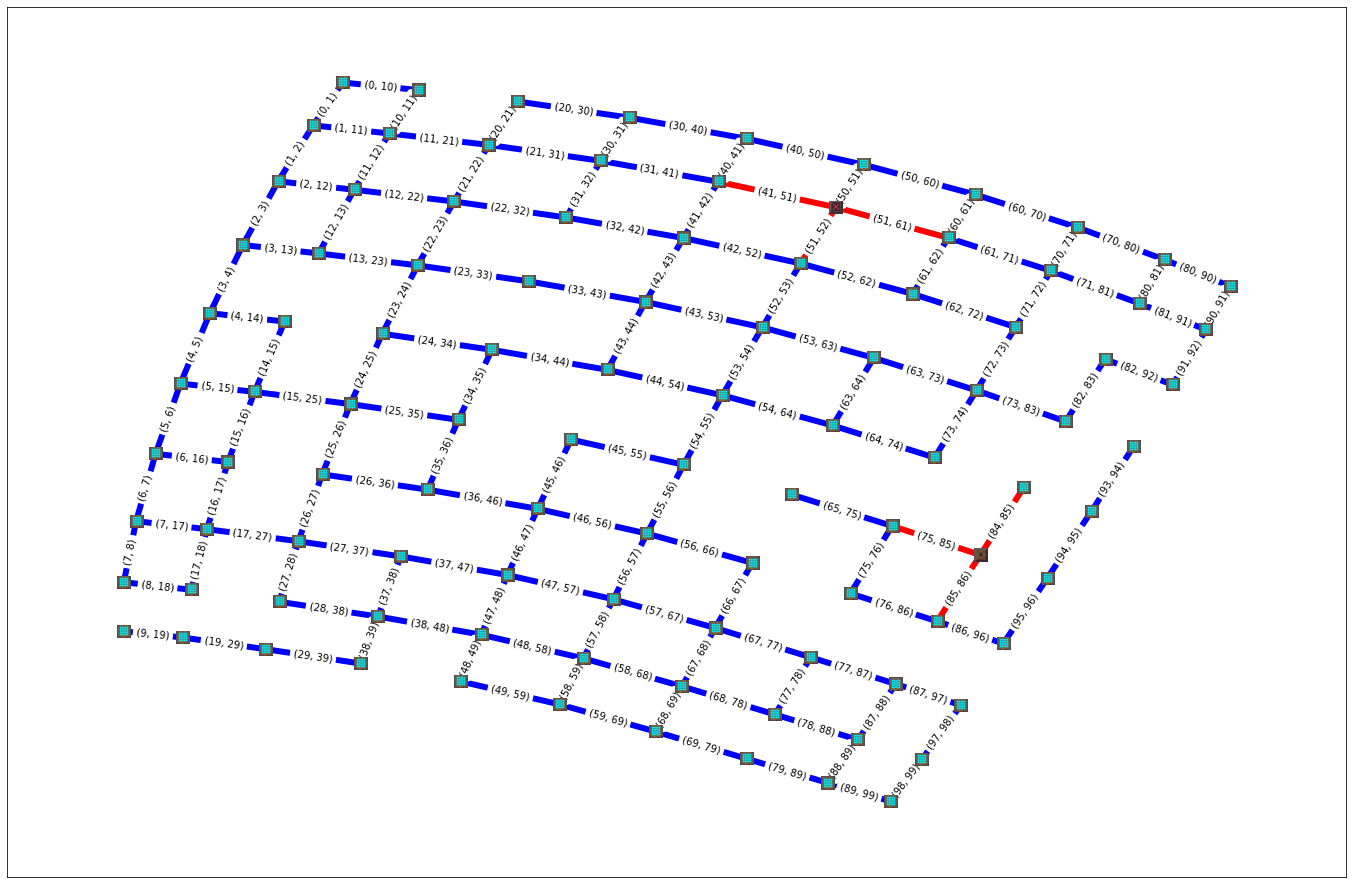

In [17]:
plot_water_network(water_network)

## Comparing the Solvers

Performing several iterations of the two solvers:

In [18]:
generator = GraphGenerator()

N = 100

time_mip = np.zeros(N)
time_cplex = np.zeros(N)

objective_mip = np.zeros(N)
objective_cplex = np.zeros(N)

for i in range(N):
    water_network = generator.water_network()
    
    start_mip = time.time()
    model_mip = mip_water_network(water_network)
    model_mip.optimize()
    end_mip = time.time()
    
    start_cplex = time.time()
    model_cplex = cplex_water_network(water_network)
    model_cplex.solve()
    end_cplex = time.time()
    
    time_mip[i] = end_mip - start_mip
    time_cplex[i] = end_cplex - start_cplex
    
    objective_mip[i] = model_mip.objective_value
    objective_cplex[i] = model_cplex.solution.get_objective_value()

Cgl0002I 7 variables fixed
Cgl0004I processed model has 243 rows, 219 columns (219 integer (219 of which binary)) and 718 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.239%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3
Cbc0038I Before mini branch and bound, 219 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After 0.02 seconds - Feasibility pump exiting with objective of 3 - took 0.00 seconds
Cbc0012I Integer solution of 3 found by feasibility pump after 0 iterations and 0 nodes (0.02 seconds)
Cbc0001I Search completed - best objective 3, took 0 iterations and 0 nodes (0.02 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU seconds):       0.02   (Wallclock seconds):       0.02

Starting solution of the Linear programming relaxation problem using Primal 

Coin0506I Presolve 292 (-22) rows, 244 (-10) columns and 868 (-62) elements
Clp1000I sum of infeasibilities 3.91482e-05 - average 1.34069e-07, 62 fixed columns
Coin0506I Presolve 292 (0) rows, 182 (-62) columns and 744 (-124) elements
Clp0006I 0  Obj 3.0071755 Dual inf 0.879912 (88)
Clp0029I End of values pass after 182 iterations
Clp0029I End of values pass after 302 iterations
Clp0029I End of values pass after 350 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000005 - largest nonzero change 2.5735924e-05 ( 0.0012867962%) - largest zero change 2.9669812e-05
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Coin0511I After Postsolve, objective 3, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 3
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Coin0511I After Postsolve, objective 3, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 3 - 0 iterations time 0.032, P

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 4 times.
MIP Presolve eliminated 154 rows and 106 columns.
Aggregator did 16 substitutions.
Reduced MIP has 100 rows, 85 columns, and 300 nonzeros.
Reduced MIP has 85 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.14 ticks)
Found incumbent of value 8.000000 after 0.02 sec. (1.22 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 6 rows and 6 columns.
Reduced MIP has 94 rows, 79 columns, and 282 nonzeros.
Reduced MIP has 79 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.19 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec

MIP Presolve eliminated 6 rows and 3 columns.
Reduced MIP has 52 rows, 45 columns, and 156 nonzeros.
Reduced MIP has 45 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.16 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.07 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            2.0000        0.0000           100.00%
      0     0        cutoff              2.0000                     20    0.00%

Root node processing (before b&c):
  Real time             =    0.06 sec. (1.89 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                  

  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec. (2.08 ticks)
Cgl0002I 6 variables fixed
Cgl0004I processed model has 277 rows, 235 columns (235 integer (235 of which binary)) and 824 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.219%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 2
Cbc0038I Before mini branch and bound, 235 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.03 seconds)
Cbc0038I After 0.03 seconds - Feasibility pump exiting with objective of 2 - took 0.00 seconds
Cbc0012I Integer solution of 2 found by feasibility pump after 0 iterations and 0 nodes (0.03 seconds)
Cbc0001I Search completed - best objective 2, took 0 iterations and 0 nodes (0.03 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU se

Coin0506I Presolve 288 (-27) rows, 242 (-12) columns and 854 (-77) elements
Clp1000I sum of infeasibilities 7.19477e-05 - average 2.49819e-07, 70 fixed columns
Coin0506I Presolve 284 (-4) rows, 172 (-70) columns and 714 (-140) elements
Clp0006I 0  Obj 1.0056713 Primal inf 1.2389936e-06 (8) Dual inf 1.5e+09 (91)
Clp0029I End of values pass after 172 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000006 - largest nonzero change 1.6147009e-05 ( 0.00080735047%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Coin0511I After Postsolve, objective 1, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 1
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Coin0511I After Postsolve, objective 1, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 1 - 0 iterations time 0.032, Presolve 0.00, Idiot 0.02

Starting MIP optimization
Version identifi

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 5 times.
MIP Presolve eliminated 184 rows and 131 columns.
Aggregator did 10 substitutions.
Reduced MIP has 46 rows, 40 columns, and 138 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.13 ticks)
Found incumbent of value 2.000000 after 0.02 sec. (1.18 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 46 rows, 40 columns, and 138 nonzeros.
Reduced MIP has 40 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.09 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (0.06 ticks)

        Nodes                  

MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.17 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            6.0000        0.0000           100.00%
*     0     0      integral     0        4.0000        4.0000       46    0.00%
Elapsed time = 0.07 sec. (1.87 ticks, tree = 0.00 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.07 sec. (1.88 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.07 sec. (1.88 ticks)
Cgl0002I 9 variables fixed
Cgl0004I processed model has 233 rows, 212 columns (212 integer (212 of which binary)) and 686 elements
Coin3009W Conflict gra

  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec. (2.37 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 264 rows, 231 columns (231 integer (231 of which binary)) and 778 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.229%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 5
Cbc0038I Before mini branch and bound, 231 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After 0.02 seconds - Feasibility pump exiting with objective of 5 - took 0.00 seconds
Cbc0012I Integer solution of 5 found by feasibility pump after 0 iterations and 0 nodes (0.02 seconds)
Cbc0001I Search completed - best objective 5, took 0 iterations and 0 nodes (0.02 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU se

Coin0506I Presolve 272 (-27) rows, 234 (-12) columns and 806 (-77) elements
Clp1000I sum of infeasibilities 6.60027e-05 - average 2.42657e-07, 61 fixed columns
Coin0506I Presolve 272 (0) rows, 173 (-61) columns and 684 (-122) elements
Clp0006I 0  Obj 1.0060637 Primal inf 2.0642615e-06 (7) Dual inf 1.8e+09 (94)
Clp0029I End of values pass after 173 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000005 - largest nonzero change 2.9031261e-05 ( 0.001451563%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Coin0511I After Postsolve, objective 1, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 1
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Coin0511I After Postsolve, objective 1, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 1 - 0 iterations time 0.022, Presolve 0.00, Idiot 0.02

Starting MIP optimization
Version identifier:

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 4 times.
MIP Presolve eliminated 123 rows and 83 columns.
Aggregator did 18 substitutions.
Reduced MIP has 160 rows, 131 columns, and 480 nonzeros.
Reduced MIP has 131 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.39 ticks)
Found incumbent of value 4.000000 after 0.02 sec. (1.49 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 160 rows, 131 columns, and 480 nonzeros.
Reduced MIP has 131 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.31 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.22 ticks)

        Nodes             

MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.22 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            6.0000        0.0000           100.00%
*     0+    0                            4.0000        0.0000           100.00%
      0     0        cutoff              4.0000        4.0000       60    0.00%
      0     0        cutoff              4.0000        4.0000       60    0.00%
Elapsed time = 0.05 sec. (1.67 ticks, tree = 0.01 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.05 sec. (1.68 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          --------

Coin0506I Presolve 241 (-33) rows, 219 (-14) columns and 710 (-96) elements
Clp1000I sum of infeasibilities 1.11447e-05 - average 4.62438e-08, 43 fixed columns
Coin0506I Presolve 241 (0) rows, 176 (-43) columns and 624 (-86) elements
Clp0006I 0  Obj 4.0036315 Dual inf 0.839916 (84)
Clp0029I End of values pass after 176 iterations
Clp0029I End of values pass after 294 iterations
Clp0029I End of values pass after 324 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000006 - largest nonzero change 2.8543944e-05 ( 0.0014271972%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Coin0511I After Postsolve, objective 4, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 4 Dual inf 0.999999 (1)
Clp0014I Perturbing problem by 0.001% of 1.0000004 - largest nonzero change 2.8543944e-05 ( 0.0014271972%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Clp0000I Opti

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 4 times.
MIP Presolve eliminated 100 rows and 64 columns.
Aggregator did 16 substitutions.
Reduced MIP has 204 rows, 164 columns, and 612 nonzeros.
Reduced MIP has 164 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.58 ticks)
Found incumbent of value 9.000000 after 0.01 sec. (1.69 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 204 rows, 164 columns, and 612 nonzeros.
Reduced MIP has 164 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.39 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.50 ticks)

        Nodes             

Presolve time = 0.01 sec. (1.34 ticks)
Found incumbent of value 4.000000 after 0.01 sec. (1.45 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 218 rows, 177 columns, and 654 nonzeros.
Reduced MIP has 177 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.42 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.43 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            4.0000        0.0000           100.00%
*     0+    0                            2.0000        0.0000           100.00%
      0     0        cutoff              2.0000        2.0000      102    0.00%
      0     0        cutoff        

Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.59 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            3.0000        0.0000           100.00%
      0     0        cutoff              3.0000                    100    0.00%

Root node processing (before b&c):
  Real time             =    0.04 sec. (2.53 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.04 sec. (2.53 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 291 rows, 239 columns (239 integer (239 of which binary)) and 866 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.215%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were domi

*     0     0      integral     0        2.0000        2.0000       14    0.00%
Elapsed time = 0.06 sec. (2.53 ticks, tree = 0.00 MB, solutions = 3)

Root node processing (before b&c):
  Real time             =    0.06 sec. (2.54 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.06 sec. (2.54 ticks)
Cgl0002I 8 variables fixed
Cgl0004I processed model has 227 rows, 209 columns (209 integer (209 of which binary)) and 670 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.251%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 2
Cbc0038I Before mini branch and bound, 209 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After

Coin0506I Presolve 255 (-18) rows, 226 (-8) columns and 758 (-51) elements
Clp1000I sum of infeasibilities 4.91336e-05 - average 1.92681e-07, 53 fixed columns
Coin0506I Presolve 252 (-3) rows, 173 (-53) columns and 652 (-106) elements
Clp0006I 0  Obj 2.0478326 Primal inf 3.0313716e-07 (4) Dual inf 1.1e+09 (88)
Clp0029I End of values pass after 173 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000006 - largest nonzero change 2.5115664e-05 ( 0.0012557832%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Coin0511I After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 2
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Coin0511I After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 2 - 0 iterations time 0.042, Presolve 0.00, Idiot 0.03

Starting MIP optimization
Version identifier

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 4 times.
MIP Presolve eliminated 105 rows and 72 columns.
Aggregator did 15 substitutions.
Reduced MIP has 184 rows, 150 columns, and 552 nonzeros.
Reduced MIP has 150 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.45 ticks)
Found incumbent of value 10.000000 after 0.02 sec. (1.55 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 184 rows, 150 columns, and 552 nonzeros.
Reduced MIP has 150 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.35 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.30 ticks)

        Nodes            

Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 198 rows, 162 columns, and 594 nonzeros.
Reduced MIP has 162 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.38 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.35 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           10.0000        0.0000           100.00%
*     0+    0                            5.0000        0.0000           100.00%
*     0     0      integral     0        4.0000        4.0000       87    0.00%
Elapsed time = 0.05 sec. (2.35 ticks, tree = 0.00 MB, solutions = 3)

Root node processing (before b&c):
  Real time             =    0.0

   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            3.0000        0.0000           100.00%
*     0+    0                            1.0000        0.0000           100.00%
      0     0        cutoff              1.0000        1.0000       58    0.00%
      0     0        cutoff              1.0000        1.0000       58    0.00%
Elapsed time = 0.05 sec. (1.92 ticks, tree = 0.01 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.05 sec. (1.93 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec. (1.93 ticks)
Cgl0002I 5 variables fixed
Cgl0004I processed model has 241 rows, 216 columns (216 integer (216 of which binary)) and 718 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.236%
C

  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.06 sec. (2.67 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 277 rows, 237 columns (237 integer (237 of which binary)) and 818 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.222%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 5
Cbc0038I Before mini branch and bound, 237 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.03 seconds)
Cbc0038I After 0.03 seconds - Feasibility pump exiting with objective of 5 - took 0.00 seconds
Cbc0012I Integer solution of 5 found by feasibility pump after 0 iterations and 0 nodes (0.03 seconds)
Cbc0001I Search completed - best objective 5, took 0 iterations and 0 nodes (0.03 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU se

Coin0506I Presolve 251 (-37) rows, 223 (-17) columns and 740 (-108) elements
Clp1000I sum of infeasibilities 4.57482e-05 - average 1.82264e-07, 66 fixed columns
Coin0506I Presolve 251 (0) rows, 157 (-66) columns and 608 (-132) elements
Clp0006I 0  Obj 4.0028799 Primal inf 7.8325464e-07 (4) Dual inf 9e+08 (72)
Clp0029I End of values pass after 157 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000006 - largest nonzero change 2.9031261e-05 ( 0.001451563%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Coin0511I After Postsolve, objective 4, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 4
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Coin0511I After Postsolve, objective 4, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 4 - 0 iterations time 0.042, Presolve 0.00, Idiot 0.03

Starting MIP optimization
Version identifier: 

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 69 rows and 46 columns.
Aggregator did 9 substitutions.
Reduced MIP has 240 rows, 191 columns, and 720 nonzeros.
Reduced MIP has 191 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.01 ticks)
Found incumbent of value 3.000000 after 0.01 sec. (1.13 ticks)
Probing time = 0.00 sec. (0.05 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 240 rows, 191 columns, and 720 nonzeros.
Reduced MIP has 191 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.46 ticks)
Probing time = 0.00 sec. (0.05 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.36 ticks)

        Nodes               

Probing time = 0.00 sec. (0.05 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.47 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            4.0000        0.0000           100.00%
      0     0        cutoff              4.0000                    122    0.00%

Root node processing (before b&c):
  Real time             =    0.04 sec. (2.87 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.04 sec. (2.87 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 297 rows, 248 columns (248 integer (248 of which binary)) and 876 elements
Coi


Root node processing (before b&c):
  Real time             =    0.07 sec. (2.64 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.07 sec. (2.64 ticks)
Cgl0002I 8 variables fixed
Cgl0004I processed model has 291 rows, 243 columns (243 integer (243 of which binary)) and 858 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.218%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 3
Cbc0038I Before mini branch and bound, 243 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After 0.02 seconds - Feasibility pump exiting with objective of 3 - took 0.00 seconds
Cbc0012I Integer solution of 3 found by feasibility pump after 0 ite

Coin0506I Presolve 287 (-23) rows, 242 (-10) columns and 852 (-66) elements
Clp1000I sum of infeasibilities 6.0766e-05 - average 2.11728e-07, 73 fixed columns
Coin0506I Presolve 287 (0) rows, 169 (-73) columns and 706 (-146) elements
Clp0006I 0  Obj 3.1842358 Primal inf 1.0474636e-06 (7) Dual inf 1.5e+09 (87)
Clp0029I End of values pass after 169 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000006 - largest nonzero change 2.9031261e-05 ( 0.001451563%) - largest zero change 2.9669812e-05
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Coin0511I After Postsolve, objective 3, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 3
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Clp0000I Optimal - objective value 3
Coin0511I After Postsolve, objective 3, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 3 - 0 iterations time 0.032, Presolve 0.00, Idiot 0.03

Starting MIP optimization
Version identifier: 

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 5 times.
MIP Presolve eliminated 98 rows and 71 columns.
Aggregator did 13 substitutions.
Reduced MIP has 188 rows, 152 columns, and 564 nonzeros.
Reduced MIP has 152 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.43 ticks)
Found incumbent of value 3.000000 after 0.01 sec. (1.53 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 188 rows, 152 columns, and 564 nonzeros.
Reduced MIP has 152 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.36 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.34 ticks)

        Nodes              


        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            5.0000        0.0000           100.00%
*     0+    0                            3.0000        0.0000           100.00%
*     0     0      integral     0        2.0000        2.0000       44    0.00%
Elapsed time = 0.04 sec. (1.99 ticks, tree = 0.00 MB, solutions = 3)

Root node processing (before b&c):
  Real time             =    0.04 sec. (2.00 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.04 sec. (2.00 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 244 rows, 218 columns (218 integer (218 of which binary)) and 722 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.239%
Cgl0015I Clique Stre

Coin0506I Presolve 252 (-37) rows, 224 (-16) columns and 742 (-107) elements
Clp1000I sum of infeasibilities 2.00574e-05 - average 7.95929e-08, 45 fixed columns
Coin0506I Presolve 252 (0) rows, 179 (-45) columns and 652 (-90) elements
Clp0006I 0  Obj 4.0031876 Primal inf 7.052812e-08 (1) Dual inf 2e+08 (90)
Clp0029I End of values pass after 179 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000005 - largest nonzero change 2.8682824e-05 ( 0.0014341412%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Coin0511I After Postsolve, objective 4, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 4
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Coin0511I After Postsolve, objective 4, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 4 - 0 iterations time 0.032, Presolve 0.00, Idiot 0.03

Starting MIP optimization
Version identifier: 2

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 136 rows and 98 columns.
MIP Presolve added 1 rows and 1 columns.
Aggregator did 8 substitutions.
Reduced MIP has 129 rows, 106 columns, and 387 nonzeros.
Reduced MIP has 105 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.10 ticks)
Found incumbent of value 3.000000 after 0.01 sec. (1.19 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 5 rows and 4 columns.
Reduced MIP has 124 rows, 101 columns, and 372 nonzeros.
Reduced MIP has 101 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.25 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threa

Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 224 rows, 181 columns, and 672 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.43 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.69 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            6.0000        0.0000           100.00%
*     0+    0                            5.0000        0.0000           100.00%
      0     0        cutoff              5.0000        5.0000      114    0.00%
      0     0        cutoff              5.0000        5.0000      114    0.00%
Elapsed time = 0.06 sec. (2.80 ticks, tree = 0.01 MB, solutions = 2)

Root node processing (bef

*     0+    0                            5.0000        0.0000           100.00%
*     0+    0                            2.0000        0.0000           100.00%
      0     0        cutoff              2.0000        2.0000       80    0.00%
      0     0        cutoff              2.0000        2.0000       80    0.00%
Elapsed time = 0.08 sec. (2.76 ticks, tree = 0.01 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.08 sec. (2.77 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.08 sec. (2.77 ticks)
Cgl0002I 5 variables fixed
Cgl0004I processed model has 260 rows, 228 columns (228 integer (228 of which binary)) and 772 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.226%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initi

Coin0506I Presolve 237 (-18) rows, 217 (-8) columns and 704 (-51) elements
Clp1000I sum of infeasibilities 4.82035e-05 - average 2.0339e-07, 49 fixed columns
Coin0506I Presolve 237 (0) rows, 168 (-49) columns and 606 (-98) elements
Clp0006I 0  Obj 2.0030146 Primal inf 4.7781637e-07 (5) Dual inf 1.2e+09 (81)
Clp0029I End of values pass after 168 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000006 - largest nonzero change 2.4903109e-05 ( 0.0012451555%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Coin0511I After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 2
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Clp0000I Optimal - objective value 2
Coin0511I After Postsolve, objective 2, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 2 - 0 iterations time 0.032, Presolve 0.00, Idiot 0.03

Starting MIP optimization
Version identifier: 2

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 3 times.
MIP Presolve eliminated 91 rows and 57 columns.
Aggregator did 14 substitutions.
Reduced MIP has 214 rows, 173 columns, and 642 nonzeros.
Reduced MIP has 173 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.40 ticks)
Found incumbent of value 4.000000 after 0.02 sec. (1.51 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 214 rows, 173 columns, and 642 nonzeros.
Reduced MIP has 173 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.42 ticks)
Probing time = 0.00 sec. (0.04 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.34 ticks)

        Nodes              

Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.16 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            2.0000        0.0000           100.00%
      0     0        cutoff              2.0000                     28    0.00%

Root node processing (before b&c):
  Real time             =    0.06 sec. (1.82 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.06 sec. (1.82 ticks)
Cgl0002I 6 variables fixed
Cgl0004I processed model has 252 rows, 222 columns (222 integer (222 of which binary)) and 750 elements
Coi

  Real time             =    0.04 sec. (1.80 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.04 sec. (1.80 ticks)
Cgl0002I 7 variables fixed
Cgl0004I processed model has 252 rows, 222 columns (222 integer (222 of which binary)) and 746 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.235%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 2
Cbc0038I Before mini branch and bound, 222 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After 0.02 seconds - Feasibility pump exiting with objective of 2 - took 0.00 seconds
Cbc0012I Integer solution of 2 found by feasibility pump after 0 iterations and 0 nodes (0.02 seconds)
C

Coin0506I Presolve 266 (-38) rows, 228 (-20) columns and 788 (-108) elements
Clp1000I sum of infeasibilities 5.99288e-05 - average 2.25296e-07, 55 fixed columns
Coin0506I Presolve 266 (0) rows, 173 (-55) columns and 678 (-110) elements
Clp0006I 0  Obj 4.1465086 Primal inf 2.2595809e-06 (6) Dual inf 1e+09 (91)
Clp0029I End of values pass after 173 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000006 - largest nonzero change 2.3094151e-05 ( 0.0011547075%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Coin0511I After Postsolve, objective 4, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 4
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Clp0000I Optimal - objective value 4
Coin0511I After Postsolve, objective 4, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 4 - 0 iterations time 0.042, Presolve 0.00, Idiot 0.04

Starting MIP optimization
Version identifier:

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 4 times.
MIP Presolve eliminated 126 rows and 92 columns.
MIP Presolve modified 3 coefficients.
Aggregator did 16 substitutions.
Reduced MIP has 136 rows, 112 columns, and 408 nonzeros.
Reduced MIP has 112 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.27 ticks)
Found incumbent of value 7.000000 after 0.02 sec. (1.36 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 136 rows, 112 columns, and 408 nonzeros.
Reduced MIP has 112 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.26 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0

Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 140 rows, 114 columns, and 420 nonzeros.
Reduced MIP has 114 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.27 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.20 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            3.0000        0.0000           100.00%
*     0     0      integral     0        2.0000        2.0000       58    0.00%
Elapsed time = 0.05 sec. (2.43 ticks, tree = 0.00 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.05 sec. (2.44 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)

*     0     0      integral     0        7.0000        7.0000      105    0.00%
Elapsed time = 0.05 sec. (2.77 ticks, tree = 0.00 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.05 sec. (2.78 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec. (2.78 ticks)
Cgl0002I 9 variables fixed
Cgl0004I processed model has 289 rows, 244 columns (244 integer (244 of which binary)) and 846 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.222%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 7
Cbc0038I Before mini branch and bound, 244 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.03 seconds)
Cbc0038I After

Coin0506I Presolve 219 (-27) rows, 203 (-16) columns and 652 (-70) elements
Clp1000I sum of infeasibilities 3.64393e-05 - average 1.66389e-07, 64 fixed columns
Coin0506I Presolve 216 (-3) rows, 139 (-64) columns and 524 (-128) elements
Clp0006I 0  Obj 1.0010057 Primal inf 8.8591e-07 (7) Dual inf 1.1e+09 (56)
Clp0029I End of values pass after 139 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000007 - largest nonzero change 2.8691903e-05 ( 0.0014345952%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Coin0511I After Postsolve, objective 1, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 1 Dual inf 0.999999 (1)
Clp0014I Perturbing problem by 0.001% of 1.0000005 - largest nonzero change 2.8691903e-05 ( 0.0014345952%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Clp0000I Optimal - objective value 1
Coin0511I After Postsolve, objective 1, infeasi

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Tried aggregator 4 times.
MIP Presolve eliminated 130 rows and 84 columns.
MIP Presolve added 1 rows and 1 columns.
Aggregator did 15 substitutions.
Reduced MIP has 141 rows, 118 columns, and 423 nonzeros.
Reduced MIP has 117 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.30 ticks)
Found incumbent of value 5.000000 after 0.01 sec. (1.39 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 5 rows and 5 columns.
Reduced MIP has 136 rows, 113 columns, and 408 nonzeros.
Reduced MIP has 113 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.27 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 thre

Presolve time = 0.01 sec. (1.13 ticks)
Found incumbent of value 9.000000 after 0.01 sec. (1.21 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 140 rows, 116 columns, and 420 nonzeros.
Reduced MIP has 116 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.27 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.25 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            9.0000        0.0000           100.00%
*     0+    0                            5.0000        0.0000           100.00%
      0     0        cutoff              5.0000        5.0000       63    0.00%
      0     0        cutoff        

*     0+    0                            8.0000        0.0000           100.00%
*     0+    0                            3.0000        0.0000           100.00%
      0     0        cutoff              3.0000        3.0000       69    0.00%
      0     0        cutoff              3.0000        3.0000       69    0.00%
Elapsed time = 0.08 sec. (2.49 ticks, tree = 0.01 MB, solutions = 2)

Root node processing (before b&c):
  Real time             =    0.08 sec. (2.50 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.08 sec. (2.50 ticks)
Cgl0002I 6 variables fixed
Cgl0004I processed model has 274 rows, 235 columns (235 integer (235 of which binary)) and 810 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.223%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initi

In [19]:
print("Checking the results of each iteration:")

print()

for i in range(100):
    if objective_mip[i] == objective_cplex[i]:
        print(f"Iter {i+1}:")
        print(f"MIP = {objective_mip[i]} ({time_mip[i]})")
        print(f"CPLEX = {objective_cplex[i]} ({time_cplex[i]})")

        print()

Checking the results of each iteration:

Iter 1:
MIP = 2.0 (0.06307530403137207)
CPLEX = 2.0 (0.13438725471496582)

Iter 2:
MIP = 4.0 (0.09038567543029785)
CPLEX = 4.0 (0.10449695587158203)

Iter 3:
MIP = 3.0 (0.07782101631164551)
CPLEX = 3.0 (0.0782623291015625)

Iter 4:
MIP = 1.0 (0.07365012168884277)
CPLEX = 1.0 (0.08634066581726074)

Iter 5:
MIP = 3.0 (0.07912325859069824)
CPLEX = 3.0 (0.09645438194274902)

Iter 6:
MIP = 3.0 (0.08542037010192871)
CPLEX = 3.0 (0.07718849182128906)

Iter 7:
MIP = 2.0 (0.08458447456359863)
CPLEX = 2.0 (0.10523128509521484)

Iter 8:
MIP = 2.0 (0.09725236892700195)
CPLEX = 2.0 (0.08732128143310547)

Iter 9:
MIP = 2.0 (0.0933985710144043)
CPLEX = 2.0 (0.08515429496765137)

Iter 10:
MIP = 3.0 (0.08730411529541016)
CPLEX = 3.0 (0.11830759048461914)

Iter 11:
MIP = 1.0 (0.079071044921875)
CPLEX = 1.0 (0.09365105628967285)

Iter 12:
MIP = 1.0 (0.07568740844726562)
CPLEX = 1.0 (0.0823514461517334)

Iter 13:
MIP = 7.0 (0.08454203605651855)
CPLEX = 7.0 (0.08896

In [20]:
print("Summarizing the results:")
print("Number of equal values obtained in the objective function =", sum(objective_mip == objective_cplex))
print("Number of iterations in which cplex achieved better efficiency =", sum(time_mip > time_cplex))

Summarizing the results:
Number of equal values obtained in the objective function = 100
Number of iterations in which cplex achieved better efficiency = 35
